### Setup

In [178]:
import pandas as pd
import altair as alt
from matplotlib.colors import LinearSegmentedColormap
import os
import itertools

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import importlib
import utils
# Cache-Probleme umgehen
importlib.reload(utils)
from utils import format_long_text
from utils import generate_model_names
from utils import save_full_workflow
from utils import load_model
from utils import load_features
from utils import load_results
from utils import full_pipeline
from utils import load_residual_plot
from utils import load_validation_results
from utils import load_summary_table

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [157]:
# Farbgebung in Diagrammen
color1 = '#06507F'  # Dunkelblau
color2 = '#330241'  # Dunkellila
color3 = '#0076BF'  # Blau
color4 = '#80BADF'  # Hellblau
color5 = '#E7DDFF'  # Helllila
custom_cmap = LinearSegmentedColormap.from_list('custom', ['#FFFFFF', color1])

### Data import

In [158]:
path_data = 'https://raw.githubusercontent.com/mm391-030401/project/refs/heads/main/data/processed/'
file_data= 'data_final.csv'

data = pd.read_csv(path_data + file_data, sep=',', encoding='utf-8')

# Obwohl diese Spalten bereits im Notebook "convert_columns" zu Strings konvertiert wurden, wurden sie beim erneuten Einlesen wieder als Integer erkannt
# Allerdings ist es sinnvoll, diese Spalten nicht als Integer (diskret) zu betrachten 
# sondern als ordinale Variablen (Rechenoperationen sind nicht sinnig für die Zeitangaben)
to_str_cols = ['monat', 'monat_jahr','monat_monat', 'kohorte', 'kohorte_jahr', 'kohorte_monat']

# Konvertierung der Spalten in string 
for col in to_str_cols: 
    data[col] = data[col].astype(str)

### Model Workflow

#### Variables


In [159]:
y_label = 'retentionrate'

In [179]:
# Liste der Strings
strings = [
    'erster_monat_kohorte_fg',
    'monate_seit_einfuehrung_programm_kohorte',
    'monat_monat',
    'kohorte_monat',
    'monat_jahreszeit',
    'kohorte_jahreszeit',
    'rabatt_indexiert'
]

# Generiere alle möglichen Kombinationen (mindestens eine der Strings)
combinations = []
for r in range(1, len(strings) + 1):
    combinations.extend(itertools.combinations(strings, r))

# Umwandeln in eine Liste von Listen
combinations = [list(comb) for comb in combinations]

In [181]:
len(combinations)

127

In [182]:
feature_list = combinations

#### Workflow

In [183]:
# Modelltyp
modeltype = "Lineare_Regression"

# Leere Liste für Modellnamen erstellen
model_names_list = []

# Iteration durch die Feature-Liste und Anwendung der full_pipeline Funktion
start_num = 3  # Beginn der Modellnummerierung

for features in feature_list:
    # Generiere den Modellnamen (dies gibt eine Liste zurück)
    model_names = generate_model_names(start_num, 1, modeltype)
    
    # Entpacke den ersten Modellnamen (oder den gewünschten Index)
    model_name = model_names[0]  # Hier entpackst du den ersten Namen der Liste
    
    # Füge den Modellnamen zur Liste hinzu
    model_names_list.append(model_name)
    
    # Rufe die Pipeline-Funktion auf
    full_pipeline(data, y_label, features=features, model_name=model_name)
    
    # Erhöhe die Modellnummer für den nächsten Durchgang
    start_num += 1

# Jetzt enthält model_names_list alle Modellnamen
print(model_names_list)


Modell gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\03_20241229-235206_Lineare_Regression.joblib
Features gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\03_20241229-235206_Lineare_Regression_features.json
Ergebnisse gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\03_20241229-235206_Lineare_Regression_results.csv
Kreuzvalidierungsergebnisse gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\03_20241229-235206_Lineare_Regression_validation.csv
Residualplot gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\03_20241229-235206_Lineare_Regression_residual_plot.png
Zusammenfassungstabelle gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\03_20241229-235206_Lineare_Regression_summary.csv

Modellzusammenfassung:
                      Name  Coefficient
0         

#### Review Models

In [199]:
# Leere Liste für alle DataFrames erstellen
all_results = []

# Iteration durch die Modellnamen und Laden der Ergebnisse
for model_name in model_names_list:
    # Lade die Evaluierungsergebnisse des Modells
    results_df = load_results(model_name)
    
    if results_df is not None:
        # Lade die verwendeten Features
        features = load_features(model_name)
        
        # Füge Modellnamen und Features als zusätzliche Spalten hinzu
        results_df['Model'] = model_name
        results_df['Features'] = str(features)  # Features als String speichern
        
        # Füge das DataFrame der Liste hinzu
        all_results.append(results_df)

# Kombiniere alle DataFrames in der Liste zu einem einzigen DataFrame
final_results_df = pd.concat(all_results, ignore_index=True)

# Setze den Modellnamen als Index
final_results_df.set_index('Model', inplace=True)

# Ausgabe des finalen DataFrames
final_results_df = final_results_df.sort_values(by = 'R_squared', ascending=False).head(10)

# Anwenden des Stylers auf das 'final_results_df', z.B. in der 'Features'-Spalte
styled_final_results = final_results_df.style.applymap(format_long_text, subset=['Features'])

# Formatierung für die numerischen Spalten, falls sie nicht gerundet sind
styled_final_results = styled_final_results.format("{:.3f}", subset=['R_squared', 'MSE', 'RMSE', 'MAE']) 

# Linksbündige Darstellung des Texts in allen Spalten
styled_final_results = styled_final_results.set_properties(**{'text-align': 'left'})

# Anzeige des formatierten DataFrames
styled_final_results

,R_squared,MSE,RMSE,MAE,Features
Model,,,,,
108_20241229-235219_Lineare_Regression,0.704,64.415,8.026,6.100,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'kohorte_monat', 'monat_jahreszeit', 'rabatt_indexiert']"
126_20241229-235222_Lineare_Regression,0.704,64.415,8.026,6.100,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'kohorte_monat', 'monat_jahreszeit', 'kohorte_jahreszeit', 'rabatt_indexiert']"
103_20241229-235218_Lineare_Regression,0.703,64.632,8.039,6.061,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'monat_monat', 'kohorte_monat', 'rabatt_indexiert']"
123_20241229-235221_Lineare_Regression,0.703,64.632,8.039,6.061,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'monat_monat', 'kohorte_monat', 'monat_jahreszeit', 'rabatt_indexiert']"
129_20241229-235222_Lineare_Regression,0.703,64.632,8.039,6.061,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'monat_monat', 'kohorte_monat', 'monat_jahreszeit', 'kohorte_jahreszeit', 'rabatt_indexiert']"
124_20241229-235221_Lineare_Regression,0.703,64.632,8.039,6.061,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'monat_monat', 'kohorte_monat', 'kohorte_jahreszeit', 'rabatt_indexiert']"
72_20241229-235214_Lineare_Regression,0.703,64.733,8.046,6.164,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'kohorte_monat', 'rabatt_indexiert']"
109_20241229-235219_Lineare_Regression,0.703,64.733,8.046,6.164,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'kohorte_monat', 'kohorte_jahreszeit', 'rabatt_indexiert']"
107_20241229-235219_Lineare_Regression,0.702,65.031,8.064,6.384,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'kohorte_monat', 'monat_jahreszeit', 'kohorte_jahreszeit']"


In [195]:
# Liste zur Speicherung der Statistiken
stats_list = []

# Iteration durch alle Modellnamen im Index von styled_final_results
for model_name in model_names_list:
    # Lade die Kreuzvalidierungsergebnisse für das Modell
    df_scores = load_validation_results(model_name)
    
    # Berechne deskriptive Statistiken und transpose sie (für bessere Lesbarkeit)
    stats = df_scores.describe().T
    
    # Füge den Modellnamen als Spalte hinzu
    stats['Model'] = model_name
    
    # Füge die Statistiken zur Liste hinzu
    stats_list.append(stats)

# Kombiniere alle Statistiken in einem DataFrame
combined_stats_df = pd.concat(stats_list)

# Setze den Modellnamen als Index
combined_stats_df = combined_stats_df.set_index('Model', append=True)

# Zeige die kombinierte Statistik-Tabelle an
combined_stats_df.sort_values(by = 'std')


count        mean        std  \
    Model                                                                  
MSE 66_20241229-235213_Lineare_Regression     5.0   62.762832   7.154904   
    102_20241229-235218_Lineare_Regression    5.0   62.762832   7.154904   
    101_20241229-235218_Lineare_Regression    5.0   62.762832   7.154904   
    122_20241229-235221_Lineare_Regression    5.0   62.762832   7.154904   
    73_20241229-235214_Lineare_Regression     5.0   76.319580   7.851032   
...                                           ...         ...        ...   
    116_20241229-235220_Lineare_Regression    5.0  207.769137  42.269510   
    86_20241229-235216_Lineare_Regression     5.0  207.769137  42.269510   
    87_20241229-235216_Lineare_Regression     5.0  207.769137  42.269510   
    17_20241229-235207_Lineare_Regression     5.0  205.051216  42.710159   
    51_20241229-235211_Lineare_Regression     5.0  205.051216  42.710159   

                                                   min         25%  \
    Model                                                            
MSE 66_20241229-235213_Lineare_Regression    53.152546   59.351100   
    102_20241229-235218_Lineare_Regression   53.152546   59.351100   
    101_20241229-235218_Lineare_Regression   53.152546   59.351100   
    122_20241229-235221_Lineare_Regression   53.152546   59.351100   
    73_20241229-235214_Lineare_Regression    64.918202   73.497862   
...                                                ...         ...   
    116_20241229-235220_Lineare_Regression  162.042558  170.130847   
    86_20241229-235216_Lineare_Regression   162.042558  170.130847   
    87_20241229-235216_Lineare_Regression   162.042558  170.130847   
    17_20241229-235207_Lineare_Regression   161.644887  162.785419   
    51_20241229-235211_Lineare_Regression   161.644887  162.785419   

                                                   50%         75%         max  
    Model                                                                       
MSE 66_20241229-235213_Lineare_Regression    62.668693   66.605450   72.036371  
    102_20241229-235218_Lineare_Regression   62.668693   66.605450   72.036371  
    101_20241229-235218_Lineare_Regression   62.668693   66.605450   72.036371  
    122_20241229-235221_Lineare_Regression   62.668693   66.605450   72.036371  
    73_20241229-235214_Lineare_Regression    75.890136   82.914963   84.376738  
...                                                ...         ...         ...  
    116_20241229-235220_Lineare_Regression  207.061738  242.569547  257.040995  
    86_20241229-235216_Lineare_Regression   207.061738  242.569547  257.040995  
    87_20241229-235216_Lineare_Regression   207.061738  242.569547  257.040995  
    17_20241229-235207_Lineare_Regression   206.284779  241.808505  252.732490  
    51_20241229-235211_Lineare_Regression   206.284779  241.808505  252.732490  

[127 rows x 8 columns]

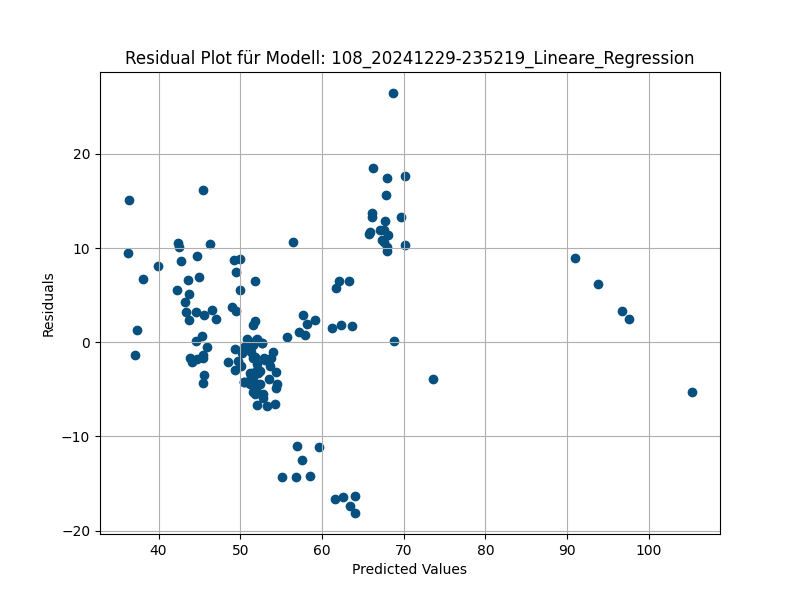

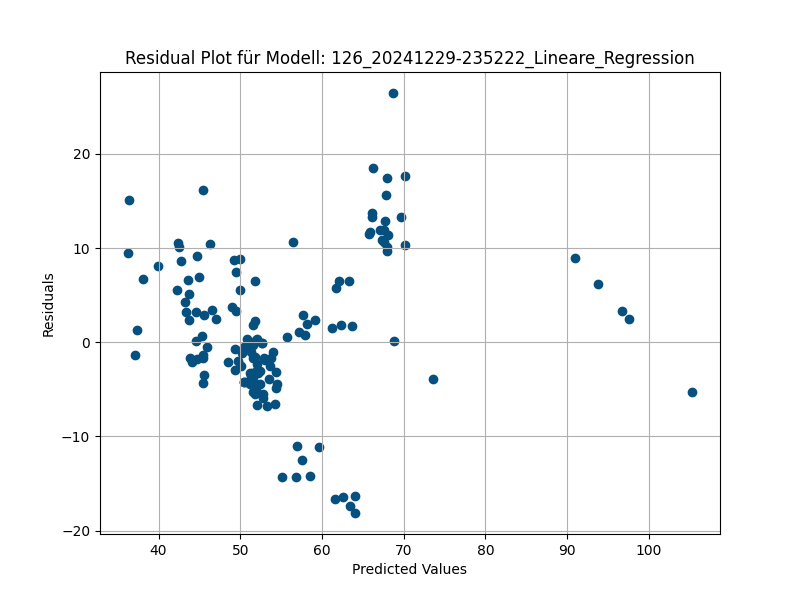

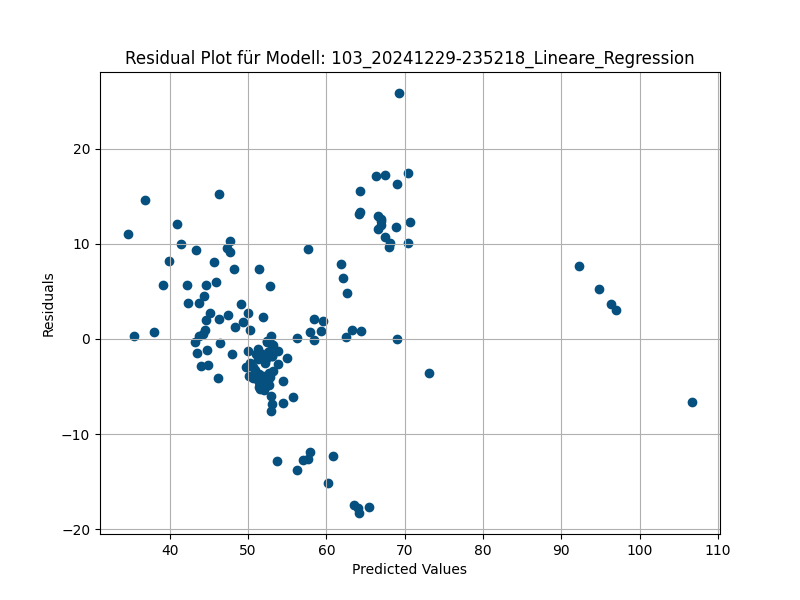

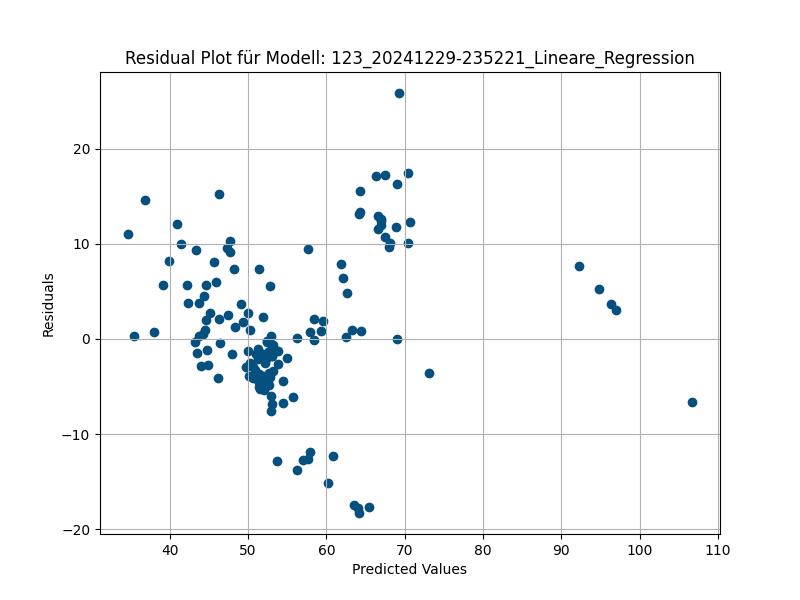

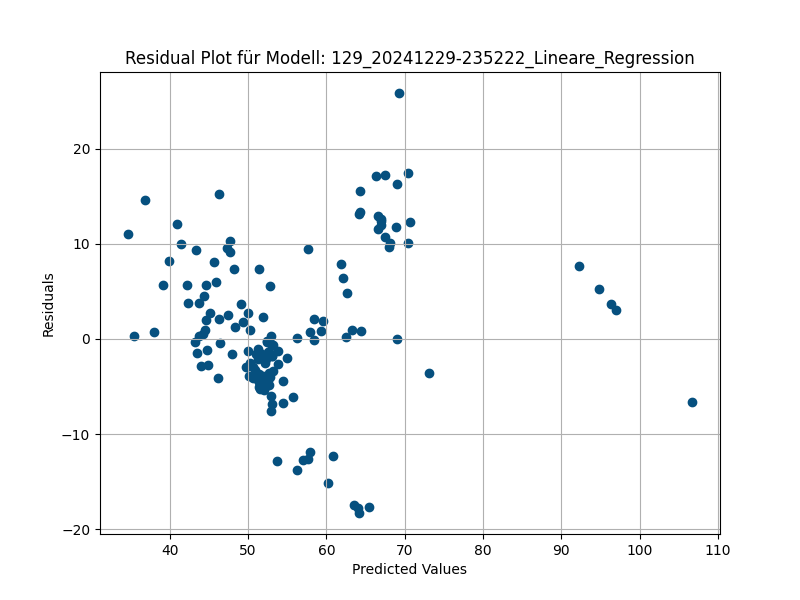

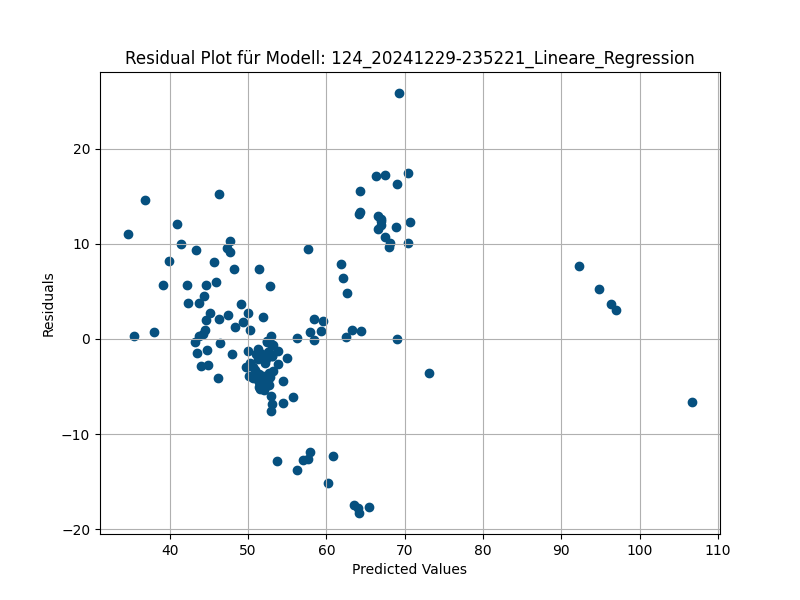

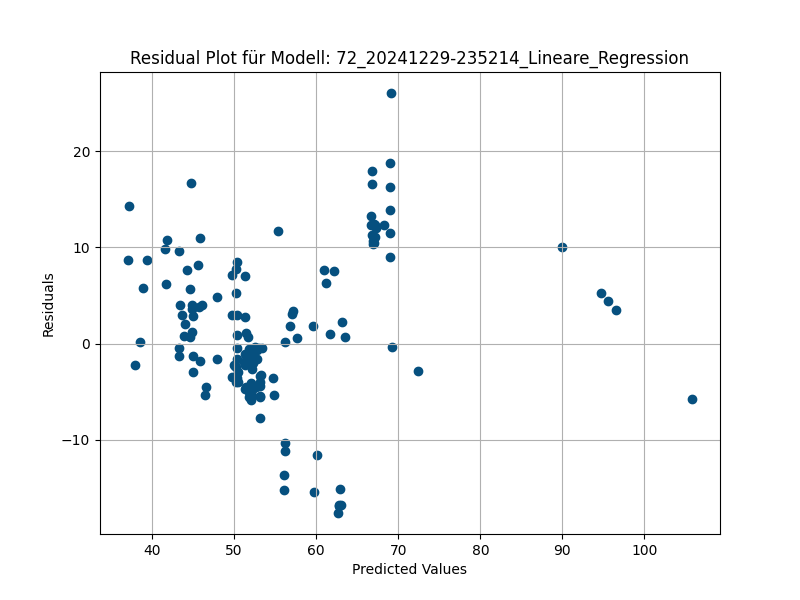

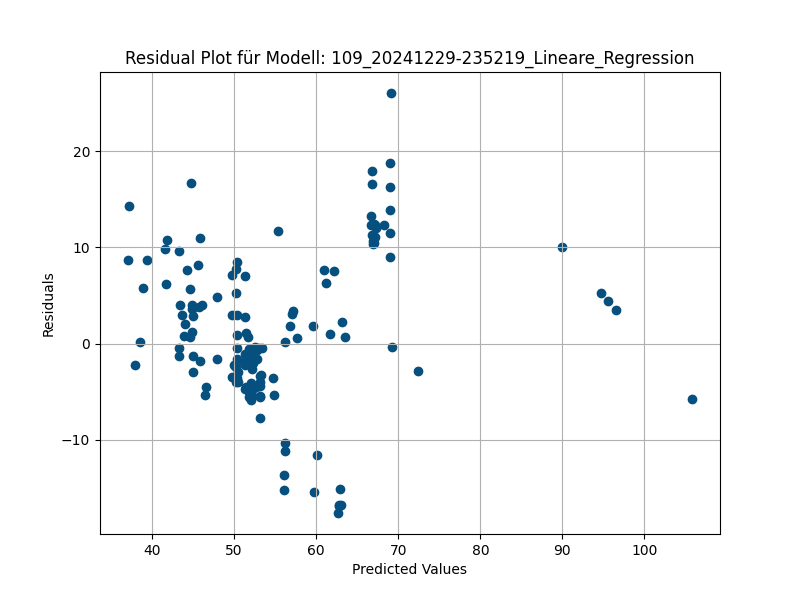

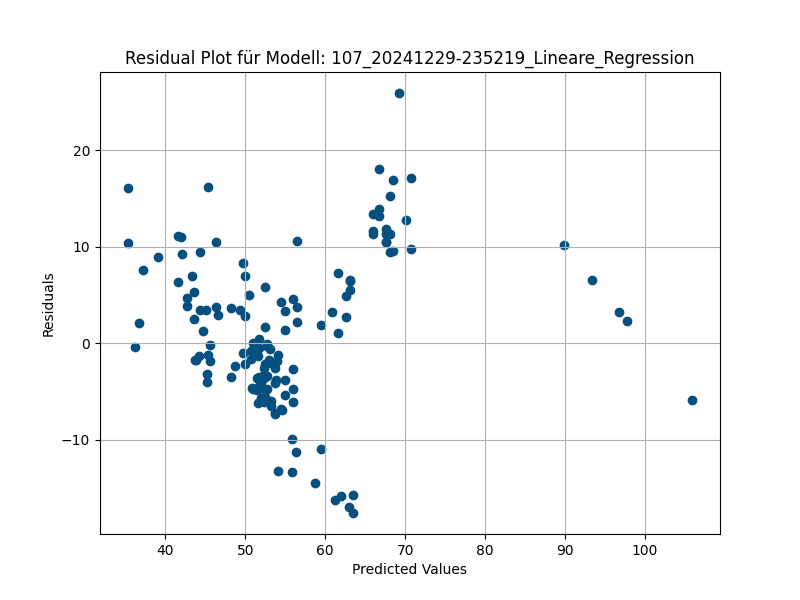

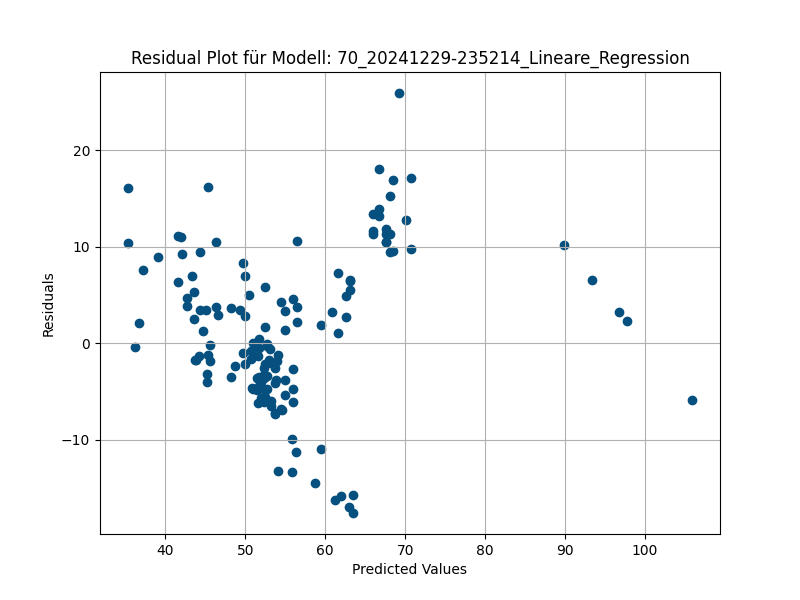

In [196]:
for name in styled_final_results.index:
    load_residual_plot(name)

In [177]:
models_dir = r"c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models"

for model_name in model_names_list:
    # Liste der Dateipfade für das Modell und die zugehörigen Dateien
    files_to_delete = [
        os.path.join(models_dir, f"{model_name}.joblib"),
        os.path.join(models_dir, f"{model_name}_features.json"),
        os.path.join(models_dir, f"{model_name}_results.csv"),
        os.path.join(models_dir, f"{model_name}_validation.csv"),
        os.path.join(models_dir, f"{model_name}_residual_plot.png"),
        os.path.join(models_dir, f"{model_name}_summary.csv")
    ]
    
    # Lösche jede Datei in der Liste
    for file_path in files_to_delete:
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"Datei {file_path} gelöscht.")
        else:
            print(f"Fehler: Datei {file_path} nicht gefunden.")

Fehler: Datei c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\03_20241229-233108_Lineare_Regression.joblib nicht gefunden.
Datei c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\03_20241229-233108_Lineare_Regression_features.json gelöscht.
Datei c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\03_20241229-233108_Lineare_Regression_results.csv gelöscht.
Datei c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\03_20241229-233108_Lineare_Regression_validation.csv gelöscht.
Datei c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\03_20241229-233108_Lineare_Regression_residual_plot.png gelöscht.
Datei c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\03_20241229-233108_Lineare_Regression_summary.csv gelöscht.
Fehler: Datei c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\04_20241229-233108_Lineare_Regression.joblib nicht gefunden.
Datei c:\Users\miche\HdM\D

### Model 1. Try

#### Variables

In [103]:
y_label = 'retentionrate'
features = ['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte']

In [104]:
# Name des aktuell getesteten Modells
model_name = '02_20241229_Lineare_Regression_Basic'

#### Pipeline

In [105]:
full_pipeline(data, y_label, features, model_name)

Modell gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\02_20241229_Lineare_Regression_Basic.joblib
Features gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\02_20241229_Lineare_Regression_Basic_features.json
Ergebnisse gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\02_20241229_Lineare_Regression_Basic_results.csv
Kreuzvalidierungsergebnisse gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\02_20241229_Lineare_Regression_Basic_validation.csv
Residualplot gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\02_20241229_Lineare_Regression_Basic_residual_plot.png
Zusammenfassungstabelle gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\02_20241229_Lineare_Regression_Basic_summary.csv

Modellzusammenfassung:
                                       Name  Coefficient

#### Model

In [106]:
load_model(model_name)

LinearRegression()

#### Training and Validation

In [107]:
df_scores = pd.DataFrame(load_validation_results(model_name))
df_scores

,MSE
0,99.282139
1,73.893149
2,87.929751
3,73.005082
4,99.436467


In [108]:
df_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
MSE,5.0,86.709317,12.976959,73.005082,73.893149,87.929751,99.282139,99.436467


#### Fit Model

In [109]:
load_summary_table(model_name)

,Name,Coefficient
0,Intercept,59.542
1,erster_monat_kohorte_fg,52.030
2,monate_seit_einfuehrung_programm_kohorte,-0.720


#### Evaluation on test set

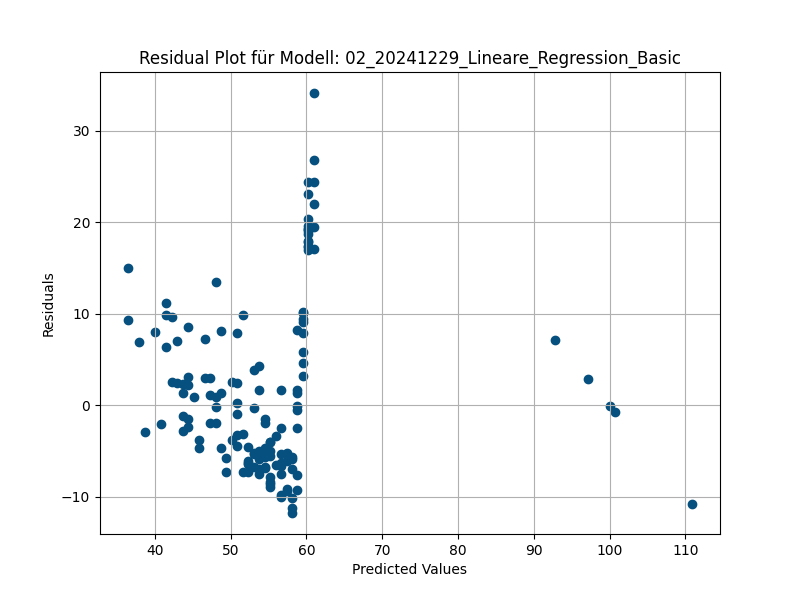

In [110]:
load_residual_plot(model_name)

In [111]:
pd.DataFrame(load_results(model_name))

,R_squared,MSE,RMSE,MAE
0,0.564548,94.883149,9.740798,7.466831
